In [84]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt


np.random.seed(1234)
tf.random.set_seed(1234)

In [85]:
tf.config.list_physical_devices('GPU')

[]

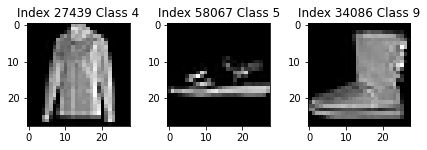

In [86]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data() # Load MNIST or FMNIST
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)


# Display randomly selected data
indices = list(np.random.randint(X_train.shape[0],size=3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(X_train[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], y_train[indices[i]]))
    plt.tight_layout()

# Important
* Always have a validation set, the procedure to create validation or dev set is by performing random sample without replacement on train set and then only using that fraction as dev set. 
* Simple approach is to set some K samples, you can extract them from start, mid or end.
* Imagine validation set that partially approximates test set distribution and we assume our model would produce identical results when we test it on test set.
* Always optimize your hyperparameters by looking at performance on validation set and not test set.
* Do not touch test set, we have this to test how our model would work on unseen data.

In [87]:
# Split train dataset into train and validation
X_val = X_train[50000:60000]
X_train = X_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example is", str(X_train.shape[1]), "by", str(X_train.shape[2]))

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example is", str(X_val.shape[1]), "by", str(X_val.shape[2]))

X_train = X_train.reshape(50000, 28*28)
X_val = X_val.reshape(10000, 28*28)
X_test = X_test.reshape(10000, 28*28)

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example has", str(X_train.shape[1]), "features")

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example has", str(X_val.shape[1]), "features")

# Split dataset into batches
#train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
#test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)

size of training set is 50000 samples
every train example is 28 by 28
size of validation set is 10000 samples
every validation example is 28 by 28
size of training set is 50000 samples
every train example has 784 features
size of validation set is 10000 samples
every validation example has 784 features


# Points to remember
* If using any type of neural network, normalize your input between 0-1.
* One can use various procedures to achieve this, divide by largest value (for images we use 255), subtract mean from data and then normalize, one can even augment them and use other steps for normalization.
* Normalization is important step, one could observe significant boost in performance just by having better normalization scheme.
* For targets we always use one-hot encodings.

In [88]:
#Normalize Data

X_train = X_train/255
X_val = X_val/255
X_test = X_test/255
# X_train[0]
np.max(X_train)

1.0

In [89]:
size_input = X_train.shape[1]
size_hidden1 = 128
size_hidden2 = 128
size_hidden3 = 128
size_output = 10

number_of_train_examples = X_train.shape[0]
number_of_test_examples = X_test.shape[0]

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) # Other function is tf.one_hot(y_train,depth=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
print(tf.shape(y_val))

tf.Tensor([10000    10], shape=(2,), dtype=int32)


# Importance of weight initialization

* One reason backprop based models can perform bettter lies with the weight initialization method, one important point one should remember is that, if yur weights are initialized to be too high or low, backprop would struggle.
* Hence one should always carefully initialize weights of your model, below i have shown approach with random_normal, one can use random_uniform, truncated version of both, Xavier init and orthogonal. 
* You will find modern day NNs have achieved stable and better performance by simply switching to better init and majority of cases Xavier or Orthogonal works best.
* Always initialize your bias using zero or some small constant (ideally 0.01 or less works better). We use bias to shift the activation and in some cases it can stabalize learning, but having large bias can cause negative results.

# Loss function

* We will always cross-entropy loss for classification.

* tf softmax,
loss= tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf)), this function is simply saying that it will calculate softmax for you, simply provide logits to it. 

* In other output of your forward pass directly goes this function. Now this operator will calculate or apply softmax over prediction or logits and calculate cross-entropy between prediction and target. I am using reduce_mean since we apply this over batches.
* Second is using keras
Method 1 :- This function requires logits, hence same as above you will pass logits or output variable to this function. Now remember you need from_logits = True, for this to work.
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
loss_x = cce(y_true_tf, y_pred_tf) 

* Method 2:- In this we will apply softmax to output function and then pass to CCE loss.
So the approach is 
output = tf.nn.softmax(output)
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
loss_x = cce(y_true_tf, y_pred_tf) 

Batch Norm Class

In [90]:
# Batch Normalization Layer

class BatchNorm(keras.layers.Layer):
    def __init__(self, dim, epsilon=10e-8, momentum=0.99):
        super(BatchNorm, self).__init__()
        self.epsilon = epsilon
        self.momentum = momentum
        self.dim = dim

        self.it_call = 0
        self.batch_size = 0

        self.mu = self.add_weight("mu", shape=[self.dim,], 
                                initializer="zeros",
                                trainable=False)
        self.var = self.add_weight("var", shape=[self.dim,], 
                                   initializer="zeros",
                                   trainable=False)

        self.gamma = self.add_weight("gamma", shape=[1, self.dim],
                                     initializer="random_normal",
                                     trainable=True)
        self.beta = self.add_weight("beta", shape=[1, self.dim],
                                    initializer="random_normal",
                                    trainable=True)
        
    
    def call(self, inputs, is_training):
        """forward
        BN(x) = gamma * ((x - mu) / sqrt(var + epsilon)) + beta
        """

        self.it_call += 1

        if is_training: 
            if self.batch_size == 0:
                self.batch_size = inputs.shape[0]
            
            batch_mu = tf.math.reduce_mean(inputs, axis=0)
            batch_var = tf.math.reduce_variance(inputs, axis=0)
            
            normalized_inputs = tf.math.divide((inputs - batch_mu), tf.math.sqrt(batch_var + self.epsilon))
            bn_inputs = tf.math.multiply(self.gamma, normalized_inputs) + self.beta

            if inputs.shape[0] == self.batch_size:
                running_mu = batch_mu
                running_var = batch_var
            else:
                running_mu = batch_mu / inputs.shape[0] * self.batch_size
                running_var = batch_var / inputs.shape[0] * self.batch_size
            
            cur_mu = running_mu * (self.momentum / self.it_call) + self.mu * (1 - (self.momentum/self.it_call))
            self.mu.assign(cur_mu)
            cur_var = running_var * (self.momentum / self.it_call) + self.var * (1 - (self.momentum/self.it_call))
            self.var.assign(cur_var)


        else: 
            normalized_inputs = tf.math.divide((inputs - self.mu), tf.math.sqrt(self.var + self.epsilon))
            bn_inputs = tf.math.multiply(self.gamma, normalized_inputs) + self.beta
        
        return bn_inputs

##Batch layer Post Non linear layer(Relu) 

In [81]:
# Define class to build mlp model
class MLP(tf.keras.Model):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    super(MLP, self).__init__()
    
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.bn = BatchNorm(128)
    self.mlp_variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
  
 def forward(self, X, is_training):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
          self.y = self.compute_output(X, is_training = is_training)
    else:
      self.y = self.compute_output(X, is_training = is_training)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

   
 def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train, True)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.mlp_variables)
    optimizer.apply_gradients(zip(grads, self.mlp_variables))

           
 def compute_output(self, X, is_training):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    # z1 = self.bn.call(z1, is_training)
    h1 = tf.nn.relu(z1)
    h1 = self.bn(h1, is_training)

    z2 = tf.matmul(h1, self.W2) + self.b2
    # z2 = self.bn.call(z2, is_training)
    h2 = tf.nn.relu(z2)
    h2 = self.bn(h2, is_training)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    # z3 = self.bn.call(z3, is_training)
    h3 = tf.nn.relu(z3)
    h3 = self.bn(h3, is_training)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)

#  def stderr(self,y_pred):
#     """
#      Calculate standard error
#      """
#     y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
#     std_dev = np.std(y_pred_tf) #Calculates standard deviation
#     std_err = std_dev/sqrt(len(y_pred_tf))
#     return std_err 


#  def var(self,y_pred):
#     """
#      Calculate variance 
#      """
#     y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
#     std_dev = np.std(y_pred_tf) #Calculates standard deviation
#     variance = (std_dev**2) # calculate variance
#     return variance

With random seed Trial: 36

Train Accuracy: 0.7339
Number of Epoch = 1 - Average Cross Entropy:= 0.014868770751953125 

Validation Accuracy: 0.7338

Train Accuracy: 0.7765
Number of Epoch = 2 - Average Cross Entropy:= 0.01063938720703125 

Validation Accuracy: 0.7728

Train Accuracy: 0.8047
Number of Epoch = 3 - Average Cross Entropy:= 0.008247590942382813 

Validation Accuracy: 0.8017

Train Accuracy: 0.8300
Number of Epoch = 4 - Average Cross Entropy:= 0.006769927978515625 

Validation Accuracy: 0.8250

Train Accuracy: 0.8431
Number of Epoch = 5 - Average Cross Entropy:= 0.005780834350585937 

Validation Accuracy: 0.8354

Train Accuracy: 0.8554
Number of Epoch = 6 - Average Cross Entropy:= 0.005088998413085938 

Validation Accuracy: 0.8486

Train Accuracy: 0.8604
Number of Epoch = 7 - Average Cross Entropy:= 0.004584326171875 

Validation Accuracy: 0.8514

Train Accuracy: 0.8646
Number of Epoch = 8 - Average Cross Entropy:= 0.004229489135742188 

Validation Accuracy: 0.8531

Train Ac

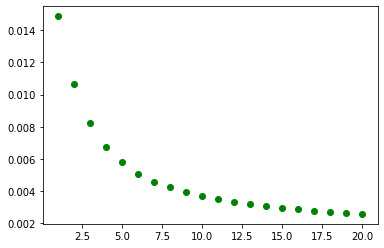


Test Accuracy = 0.8676

Total time taken (in seconds): 407.24
With random seed Trial: 27

Train Accuracy: 0.7138
Number of Epoch = 1 - Average Cross Entropy:= 0.0148889990234375 

Validation Accuracy: 0.7130

Train Accuracy: 0.7703
Number of Epoch = 2 - Average Cross Entropy:= 0.010623326416015625 

Validation Accuracy: 0.7690

Train Accuracy: 0.7950
Number of Epoch = 3 - Average Cross Entropy:= 0.008247805786132812 

Validation Accuracy: 0.7937

Train Accuracy: 0.8213
Number of Epoch = 4 - Average Cross Entropy:= 0.006766738891601562 

Validation Accuracy: 0.8158

Train Accuracy: 0.8397
Number of Epoch = 5 - Average Cross Entropy:= 0.005790240478515625 

Validation Accuracy: 0.8335

Train Accuracy: 0.8470
Number of Epoch = 6 - Average Cross Entropy:= 0.005107935180664063 

Validation Accuracy: 0.8386

Train Accuracy: 0.8590
Number of Epoch = 7 - Average Cross Entropy:= 0.0046115365600585935 

Validation Accuracy: 0.8479

Train Accuracy: 0.8620
Number of Epoch = 8 - Average Cross Entr

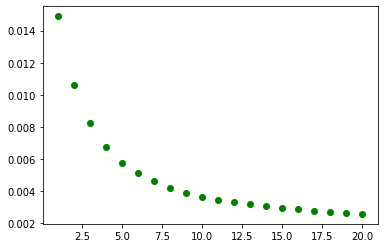


Test Accuracy = 0.8647

Total time taken (in seconds): 386.75
With random seed Trial: 61

Train Accuracy: 0.7404
Number of Epoch = 1 - Average Cross Entropy:= 0.014954661865234375 

Validation Accuracy: 0.7414

Train Accuracy: 0.7756
Number of Epoch = 2 - Average Cross Entropy:= 0.010462078857421874 

Validation Accuracy: 0.7763

Train Accuracy: 0.7972
Number of Epoch = 3 - Average Cross Entropy:= 0.008013301391601562 

Validation Accuracy: 0.7931

Train Accuracy: 0.8196
Number of Epoch = 4 - Average Cross Entropy:= 0.006563389282226563 

Validation Accuracy: 0.8141

Train Accuracy: 0.8382
Number of Epoch = 5 - Average Cross Entropy:= 0.00562985595703125 

Validation Accuracy: 0.8298

Train Accuracy: 0.8513
Number of Epoch = 6 - Average Cross Entropy:= 0.004977303771972657 

Validation Accuracy: 0.8426

Train Accuracy: 0.8534
Number of Epoch = 7 - Average Cross Entropy:= 0.004500192565917969 

Validation Accuracy: 0.8467

Train Accuracy: 0.8626
Number of Epoch = 8 - Average Cross Entr

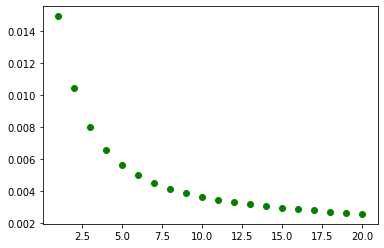


Test Accuracy = 0.8711

Total time taken (in seconds): 401.53


In [83]:
# Set number of epochs
NUM_EPOCHS = 20

seeds = np.random.randint(12,132,3)
test_acc_total = []

# Initialize model using CPU
time_start = time.time()

for i in seeds:
  tf.random.set_seed(i)
  mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')
  time_start = time.time()
  print("With random seed Trial:",i)

  for epoch in range(NUM_EPOCHS):
      
    loss_total = tf.zeros([1,1], dtype=tf.float32)
    lt = 0
      
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(1234)).batch(128)
    kz = 0
    accuracy_z = 0.0
    cur_train_acc = 0.0
    for inputs, outputs in train_ds:
      qw, tr = tf.shape(inputs)
      kz = kz + 1
      preds = mlp_on_cpu.forward(inputs, True) 
      loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
      lt = lt + mlp_on_cpu.loss(preds, outputs)
      mlp_on_cpu.backward(inputs, outputs)

    preds = mlp_on_cpu.forward(X_train, True)
    # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
    preds = tf.nn.softmax(preds)
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
    accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_train_acc += accuracy_z.numpy()
    ds = cur_train_acc
    print('\nTrain Accuracy: {:.4f}'.format(ds))
    print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
    preds_val = mlp_on_cpu.forward(X_val, True)
    preds_val = tf.nn.softmax(preds_val)
    correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_val_acc = accuracy.numpy()

    print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
    

    plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

  plt.show()        
  time_taken = time.time() - time_start
    
  # Validate model
    
  # Test Model
  preds = mlp_on_cpu.forward(X_test, False)
  pred = np.argmax(preds, axis = 1)
  y_true = np.argmax(y_test, axis = 1)
  test_acc = (pred == y_true).mean()
  test_acc_total.append(test_acc)

  print('\nTest Accuracy = {}'.format(test_acc))

  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
   

#For per epoch_time = Total_Time / Number_of_epochs

##Batch layer pre Relu

In [91]:
# Define class to build mlp model
class MLP(tf.keras.Model):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    super(MLP, self).__init__()
    
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.bn = BatchNorm(128)
    self.mlp_variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
  
 def forward(self, X, is_training):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
          self.y = self.compute_output(X, is_training = is_training)
    else:
      self.y = self.compute_output(X, is_training = is_training)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

   
 def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate =0.1)
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train, True)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.mlp_variables)
    optimizer.apply_gradients(zip(grads, self.mlp_variables))

           
 def compute_output(self, X, is_training):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    z1 = self.bn(z1, is_training)
    h1 = tf.nn.relu(z1)
    # h1 = self.bn(h1, is_training)

    z2 = tf.matmul(h1, self.W2) + self.b2
    z2 = self.bn(z2, is_training)
    h2 = tf.nn.relu(z2)
    # h2 = self.bn(h2, is_training)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    z3 = self.bn(z3, is_training)
    h3 = tf.nn.relu(z3)
    # h3 = self.bn(h3, is_training)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)

#  def stderr(self,y_pred):
#     """
#      Calculate standard error
#      """
#     y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
#     std_dev = np.std(y_pred_tf) #Calculates standard deviation
#     std_err = std_dev/sqrt(len(y_pred_tf))
#     return std_err 


#  def var(self,y_pred):
#     """
#      Calculate variance 
#      """
#     y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
#     std_dev = np.std(y_pred_tf) #Calculates standard deviation
#     variance = (std_dev**2) # calculate variance
#     return variance

With random seed Trial: 65

Train Accuracy: 0.6736
Number of Epoch = 1 - Average Cross Entropy:= 0.01608033203125 

Validation Accuracy: 0.6695

Train Accuracy: 0.7525
Number of Epoch = 2 - Average Cross Entropy:= 0.012490777587890625 

Validation Accuracy: 0.7534

Train Accuracy: 0.7704
Number of Epoch = 3 - Average Cross Entropy:= 0.009962828979492187 

Validation Accuracy: 0.7697

Train Accuracy: 0.7817
Number of Epoch = 4 - Average Cross Entropy:= 0.008333723754882812 

Validation Accuracy: 0.7787

Train Accuracy: 0.7915
Number of Epoch = 5 - Average Cross Entropy:= 0.007238648681640625 

Validation Accuracy: 0.7890

Train Accuracy: 0.8026
Number of Epoch = 6 - Average Cross Entropy:= 0.00648501220703125 

Validation Accuracy: 0.7966

Train Accuracy: 0.8161
Number of Epoch = 7 - Average Cross Entropy:= 0.005910098266601563 

Validation Accuracy: 0.8110

Train Accuracy: 0.8325
Number of Epoch = 8 - Average Cross Entropy:= 0.00545153076171875 

Validation Accuracy: 0.8236

Train Accu

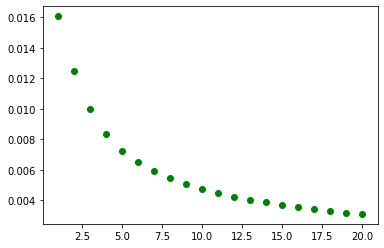


Test Accuracy = 0.8668

Total time taken (in seconds): 416.55
With random seed Trial: 88

Train Accuracy: 0.6141
Number of Epoch = 1 - Average Cross Entropy:= 0.01619162841796875 

Validation Accuracy: 0.6113

Train Accuracy: 0.7036
Number of Epoch = 2 - Average Cross Entropy:= 0.013278367919921876 

Validation Accuracy: 0.6997

Train Accuracy: 0.7341
Number of Epoch = 3 - Average Cross Entropy:= 0.011117537841796876 

Validation Accuracy: 0.7282

Train Accuracy: 0.7642
Number of Epoch = 4 - Average Cross Entropy:= 0.0094838623046875 

Validation Accuracy: 0.7562

Train Accuracy: 0.7833
Number of Epoch = 5 - Average Cross Entropy:= 0.008268870239257813 

Validation Accuracy: 0.7733

Train Accuracy: 0.7962
Number of Epoch = 6 - Average Cross Entropy:= 0.0073530010986328125 

Validation Accuracy: 0.7884

Train Accuracy: 0.8127
Number of Epoch = 7 - Average Cross Entropy:= 0.006662476196289063 

Validation Accuracy: 0.8046

Train Accuracy: 0.8264
Number of Epoch = 8 - Average Cross Entro

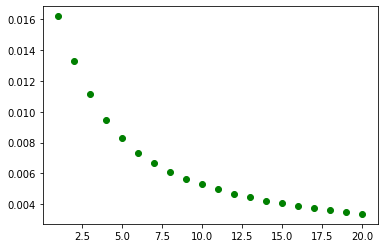


Test Accuracy = 0.8631

Total time taken (in seconds): 370.82
With random seed Trial: 128

Train Accuracy: 0.6740
Number of Epoch = 1 - Average Cross Entropy:= 0.01655779541015625 

Validation Accuracy: 0.6727

Train Accuracy: 0.7024
Number of Epoch = 2 - Average Cross Entropy:= 0.013944659423828125 

Validation Accuracy: 0.7004

Train Accuracy: 0.7229
Number of Epoch = 3 - Average Cross Entropy:= 0.0117944921875 

Validation Accuracy: 0.7182

Train Accuracy: 0.7497
Number of Epoch = 4 - Average Cross Entropy:= 0.01015843017578125 

Validation Accuracy: 0.7445

Train Accuracy: 0.7772
Number of Epoch = 5 - Average Cross Entropy:= 0.008909566650390626 

Validation Accuracy: 0.7734

Train Accuracy: 0.7960
Number of Epoch = 6 - Average Cross Entropy:= 0.007936132202148437 

Validation Accuracy: 0.7939

Train Accuracy: 0.8097
Number of Epoch = 7 - Average Cross Entropy:= 0.007156685180664062 

Validation Accuracy: 0.8085

Train Accuracy: 0.8242
Number of Epoch = 8 - Average Cross Entropy:=

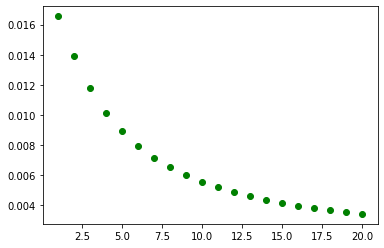


Test Accuracy = 0.8645

Total time taken (in seconds): 376.45


In [92]:
# Set number of epochs
NUM_EPOCHS = 20

seeds = np.random.randint(12,132,3)
test_acc_total = []

# Initialize model using CPU
time_start = time.time()

for i in seeds:
  tf.random.set_seed(i)
  mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')
  time_start = time.time()
  print("With random seed Trial:",i)

  for epoch in range(NUM_EPOCHS):
      
    loss_total = tf.zeros([1,1], dtype=tf.float32)
    lt = 0
      
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(1234)).batch(128)
    kz = 0
    accuracy_z = 0.0
    cur_train_acc = 0.0
    for inputs, outputs in train_ds:
      qw, tr = tf.shape(inputs)
      kz = kz + 1
      preds = mlp_on_cpu.forward(inputs, True) 
      loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
      lt = lt + mlp_on_cpu.loss(preds, outputs)
      mlp_on_cpu.backward(inputs, outputs)

    preds = mlp_on_cpu.forward(X_train, True)
    # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
    preds = tf.nn.softmax(preds)
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
    accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_train_acc += accuracy_z.numpy()
    ds = cur_train_acc
    print('\nTrain Accuracy: {:.4f}'.format(ds))
    print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
    preds_val = mlp_on_cpu.forward(X_val, True)
    preds_val = tf.nn.softmax(preds_val)
    correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_val_acc = accuracy.numpy()

    print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
    

    plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

  plt.show()        
  time_taken = time.time() - time_start
    
  # Validate model
    
  # Test Model
  preds = mlp_on_cpu.forward(X_test, False)
  pred = np.argmax(preds, axis = 1)
  y_true = np.argmax(y_test, axis = 1)
  test_acc = (pred == y_true).mean()
  test_acc_total.append(test_acc)

  print('\nTest Accuracy = {}'.format(test_acc))

  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
   

#For per epoch_time = Total_Time / Number_of_epochs